# Identification of selective sweeps

## Setup

In [3]:
# Load require packages
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [4]:
# Prefix for results
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

### Functions

In [5]:
# Function to load windowd thetas 
load_windowed_thetas <- function(path){
    habitat <- str_extract(basename(path), '(?<=allSites_)(\\w+)(?=_windowed)')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(tp_scaled = tP / nSites,
               habitat = habitat) %>%
        dplyr::select(-tF, -tH, -tL, -fuf, -fud, -fayh, -zeng, -tW, -tP, -starts_with('#'))
    return(df)
}

# Function to load windowed Fst
load_windowed_fst <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_allSites)')
    hab_comb <- str_extract(basename(path), '(?<=allSites_)(\\w+_\\w+)(?=_windowed)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst))
    
    return(df)
}

# Function to find outliers. 
find_outliers <- function(df){
    
    # Identify cutoffs of empirical distributions used for definigin outliers
    fst_quant_filt <- quantile(df %>% pull(fst), probs = c(0.99))
    tp_quant_filt <- quantile(df %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
    td_quant_filt <- quantile(df %>% pull(delta_td_ur), probs = c(0.01, 0.99))
    
    outlier_df <- df %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
    
    return(outlier_df)
}

## SFS-based tests

- I estimated $\theta_{\pi}$, Tajima's D, and $F_{ST}$ in 5 Kb windows across the genome with a 1 Kb step
- For each window, I will estimate the difference in $\theta_{\pi}$ and Tajima's D between urban and rural habitats (i.e., $\Delta\theta_{\pi}$ and $\Delta$Td)
- I'll define outlier regions as those with:
    1. Lower/Higher $\Delta\theta_{\pi}$ than the genome-wide average
    2. Lower/Higher $\Delta$Td than the genome-wide average
    3. Higher $F_{ST}$ than the genome-wide average

In [6]:
# Load Fst
fst_path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byHabitat/allSites')
fst_df <- list.files(fst_path, recursive = TRUE, full.names = TRUE, pattern = '.+_allSites_Urban_Rural_windowed.fst') %>%
    purrr::map_dfr(., load_windowed_fst) %>%
    mutate(region = paste(Chr, '_', WinCenter))

In [7]:
# Load summary stats (i.e., pi and Tajima's D)
# Currently ignores suburban habitats
thetas_path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byHabitat/allSites')
thetas_df <- list.files(thetas_path, recursive = TRUE, pattern = '.+_allSites_(Rural|Urban)_windowedThetas.gz.pestPG', full.names = TRUE) %>%
    purrr::map_dfr(., load_windowed_thetas)

In [8]:
# Convert to wide format for calculating habitat differences, etc
thetas_df_wide <- thetas_df %>% 
    pivot_wider(values_from = c('Tajima', 'nSites', 'tp_scaled'), names_from = 'habitat') %>%
    mutate(region = paste(Chr, '_', WinCenter))

In [40]:
# Combine windowed theta and fst estimates into single df
# Calculate difference in pi and Tajima's D
total_windows_theta <- nrow(thetas_df_wide)
total_windows_fst <- nrow(fst_df)

allStats_windowed_df <- thetas_df_wide %>%
    filter(region %in% fst_df$region) %>%
    left_join(., fst_df, by = c('region', 'Chr', 'WinCenter')) %>%
    mutate(delta_tp_ur = tp_scaled_Urban - tp_scaled_Rural,
           delta_td_ur = Tajima_Urban - Tajima_Rural) %>%
    dplyr::select(region, everything())

total_windows_allStats <- nrow(allStats_windowed_df)

print(sprintf('There are %s windows with estimates of fst and %s windows with estimates of thetas', total_windows_fst, total_windows_theta))
print(sprintf('%s windows were missing from the Fst Dataframe. %s windows remaining', total_windows_theta - total_windows_allStats, total_windows_allStats))

[1] "There are 806851 windows with estimates of fst and 892381 windows with estimates of thetas"
[1] "85530 windows were missing from the Fst Dataframe. 806851 windows remaining"


In [10]:
testChr_allStats <- allStats_windowed_df %>%
    filter(Chr == 'CM019102.1')

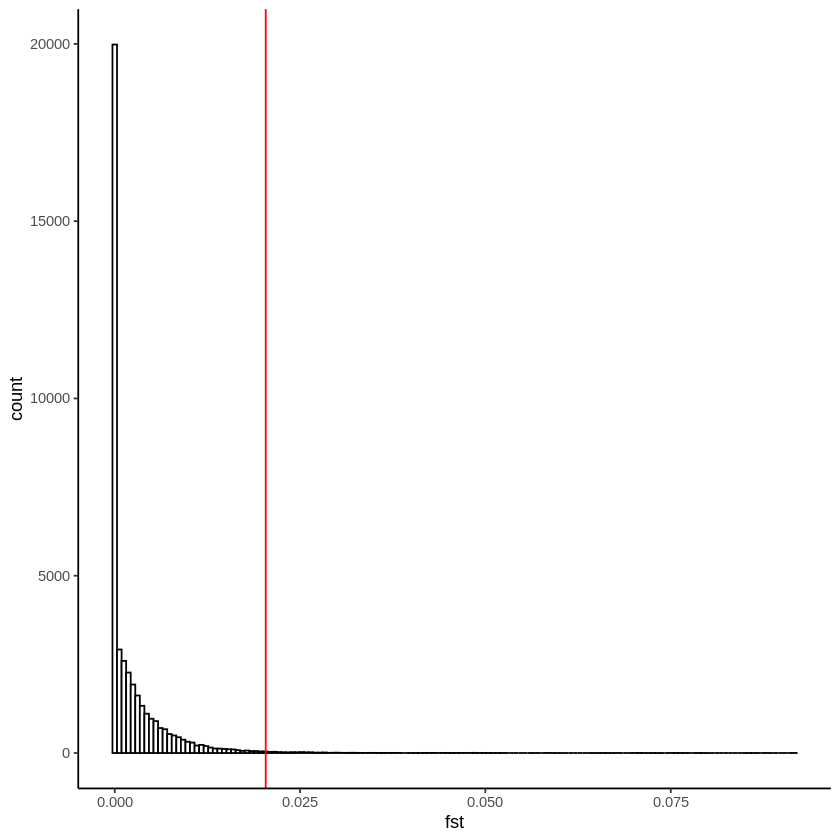

In [11]:
# Quick histogram of the distribution of windowed Fst values
# Red line is 99th percentile
# Use only windows with great than `nSites_thresh`
nSites_thresh <- 2000
testChr_allStats_filt <- testChr_allStats %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(testChr_allStats_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(testChr_allStats_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(testChr_allStats_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

testChr_allStats_filt %>%
    ggplot(., aes(x = fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    geom_vline(xintercept = fst_quant_filt, color = 'red') + 
    theme_classic()

In [12]:
testChr_allStats_filt <- testChr_allStats_filt %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))

In [13]:
testChr_allStats_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the `.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,39881
0,0,1,561
0,1,0,587
0,1,1,158
1,0,0,283
1,0,1,46
1,1,0,20
1,1,1,69


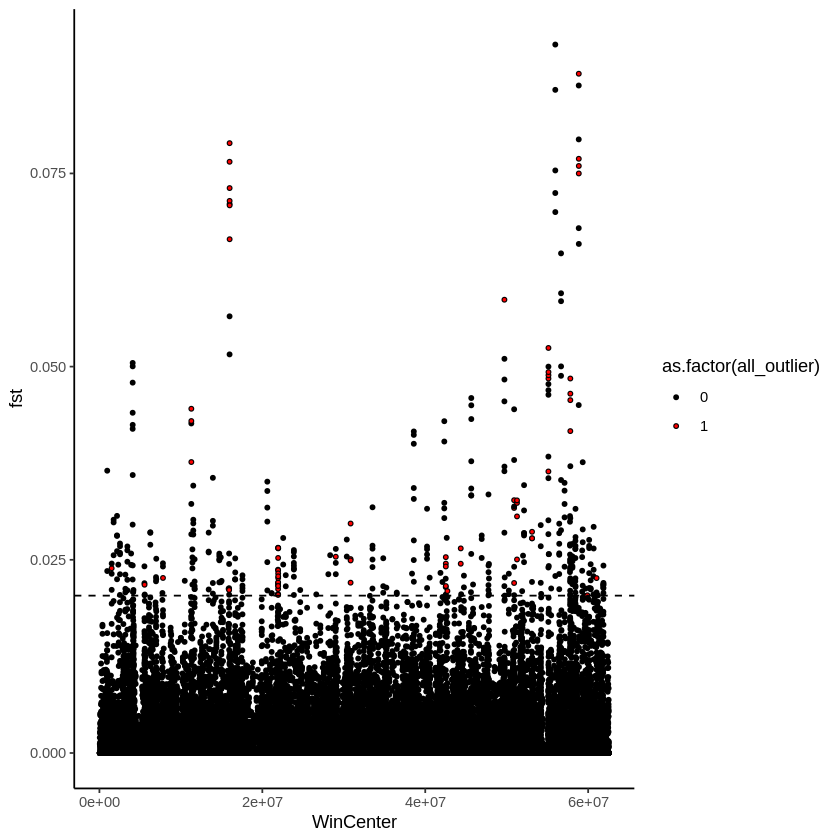

In [14]:
testChr_allStats_filt %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 1, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant_filt, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        theme_classic()

In [88]:
# Identify outliers across genome
fst_quant_filt <- quantile(allStats_windowed_df %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(allStats_windowed_df %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(allStats_windowed_df %>% pull(delta_td_ur), probs = c(0.01, 0.99))

fst_vals <- allStats_windowed_df %>% pull(fst)
num_sites <- nrow(fst_quant_filt)

allStats_windowed_df <- allStats_windowed_df %>%
mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
       tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
       td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
       all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))

In [89]:
head(allStats_windowed_df)

region,Chr,WinCenter,Tajima_Rural,Tajima_Urban,nSites_Rural,nSites_Urban,tp_scaled_Rural,tp_scaled_Urban,nSites_fst,fst,delta_tp_ur,delta_td_ur,fst_outlier,tp_outlier,td_outlier,all_outlier,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
CM019101.1 _ 13500,CM019101.1,13500,-1.081114,-1.271377,559,375,0.01309933,0.007125539,371,0,-0.0059737869,-0.190263,0,1,0,0,TRUE
CM019101.1 _ 14500,CM019101.1,14500,-0.710161,-0.687753,479,483,0.01292513,0.010695559,476,0,-0.0022295725,0.022408,0,0,0,0,TRUE
CM019101.1 _ 15500,CM019101.1,15500,-0.601823,-0.553774,1245,1222,0.01125067,0.009814513,1215,0,-0.0014361592,0.048049,0,0,0,0,TRUE
CM019101.1 _ 16500,CM019101.1,16500,-0.732648,-0.623450,1385,1371,0.01067788,0.009723503,1343,0,-0.0009543740,0.109198,0,0,0,0,TRUE
CM019101.1 _ 17500,CM019101.1,17500,-0.753305,-0.566911,2196,2185,0.01117766,0.010306269,2154,0,-0.0008713935,0.186394,0,0,0,0,TRUE
CM019101.1 _ 18500,CM019101.1,18500,-0.732448,-0.673284,2907,2942,0.01103374,0.009829857,2864,0,-0.0012038824,0.059164,0,0,0,0,TRUE


In [90]:
allStats_windowed_df %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the `.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,773649
0,0,1,9999
0,1,0,11099
0,1,1,4035
1,0,0,5680
1,0,1,1382
1,1,0,285
1,1,1,722


In [43]:
allStats_windowed_df %>% 
    filter(all_outlier == 1) %>%
    mutate(direction = ifelse(delta_tp_ur < 0 & delta_td_ur < 0, 'Urban lower', 'Rural lower')) %>%
    group_by(direction) %>%
    summarise(n = n())

direction,n
<chr>,<int>
Rural lower,405
Urban lower,317


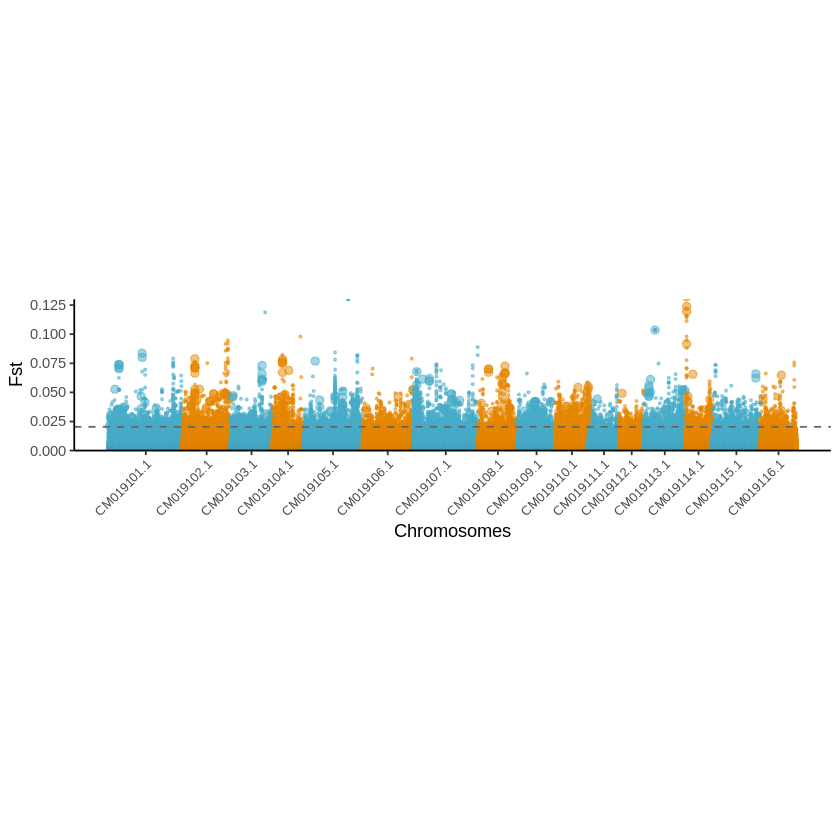

In [107]:
data_cum <- allStats_windowed_df %>% 
    group_by(Chr) %>% 
    summarise(max_WinCenter = max(WinCenter)) %>% 
    mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
    dplyr::select(Chr, WinCenter_add)

allStats_windowed_df_mod <- allStats_windowed_df %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(WinCenter_cum = WinCenter + WinCenter_add) 

axis_set <- allStats_windowed_df_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(WinCenter_cum))

outliers <- allStats_windowed_df_mod %>% filter(all_outlier == 1)

manhat_plot <- allStats_windowed_df_mod %>%
#     filter(!(region %in% outliers$region)) %>%
#     sample_frac(0.1) %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    ggplot(aes(x = WinCenter_cum, y = fst)) +
        geom_point(shape = 21, alpha = 0.5, aes(fill = chrom_cat, color = chrom_cat, size = as.factor(all_outlier))) +
#         geom_point(data=outliers, size = 1, alpha = 0.5, shape = 21, fill = '#B40F20', color = '#B40F20') +
        geom_hline(yintercept = fst_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(0, 0.13)) +
        scale_fill_manual(values = c("#46ACC8", "#E58601")) + 
        scale_color_manual(values = c("#46ACC8", "#E58601")) + 
        scale_size_manual(values = c(0.5,2)) +
        ylab('Fst') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            aspect.ratio = 0.2,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text.x = element_text(angle = 45, size = 8,hjust = 1)
          )
manhat_plot

In [108]:
outpath <- './test_manhattan.png'
ggsave(filename = outpath, plot = manhat_plot, device = 'png', width = 16, height = 6, units = 'in',
      dpi = 600)

In [33]:
head(allStats_windowed_df)

region,Chr,WinCenter,Tajima_Rural,Tajima_Urban,nSites_Rural,nSites_Urban,tp_scaled_Rural,tp_scaled_Urban,nSites_fst,fst,delta_tp_ur,delta_td_ur,fst_outlier,tp_outlier,td_outlier,all_outlier,WinCenter_add.x,WinCenter_cum,WinCenter_add.y
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CM019101.1 _ 13500,CM019101.1,13500,-1.081114,-1.271377,559,375,0.01309933,0.007125539,371,0,-0.0059737869,-0.190263,0,1,0,0,0,13500,0
CM019101.1 _ 14500,CM019101.1,14500,-0.710161,-0.687753,479,483,0.01292513,0.010695559,476,0,-0.0022295725,0.022408,0,0,0,0,0,14500,0
CM019101.1 _ 15500,CM019101.1,15500,-0.601823,-0.553774,1245,1222,0.01125067,0.009814513,1215,0,-0.0014361592,0.048049,0,0,0,0,0,15500,0
CM019101.1 _ 16500,CM019101.1,16500,-0.732648,-0.623450,1385,1371,0.01067788,0.009723503,1343,0,-0.0009543740,0.109198,0,0,0,0,0,16500,0
CM019101.1 _ 17500,CM019101.1,17500,-0.753305,-0.566911,2196,2185,0.01117766,0.010306269,2154,0,-0.0008713935,0.186394,0,0,0,0,0,17500,0
CM019101.1 _ 18500,CM019101.1,18500,-0.732448,-0.673284,2907,2942,0.01103374,0.009829857,2864,0,-0.0012038824,0.059164,0,0,0,0,0,18500,0


## Playing around

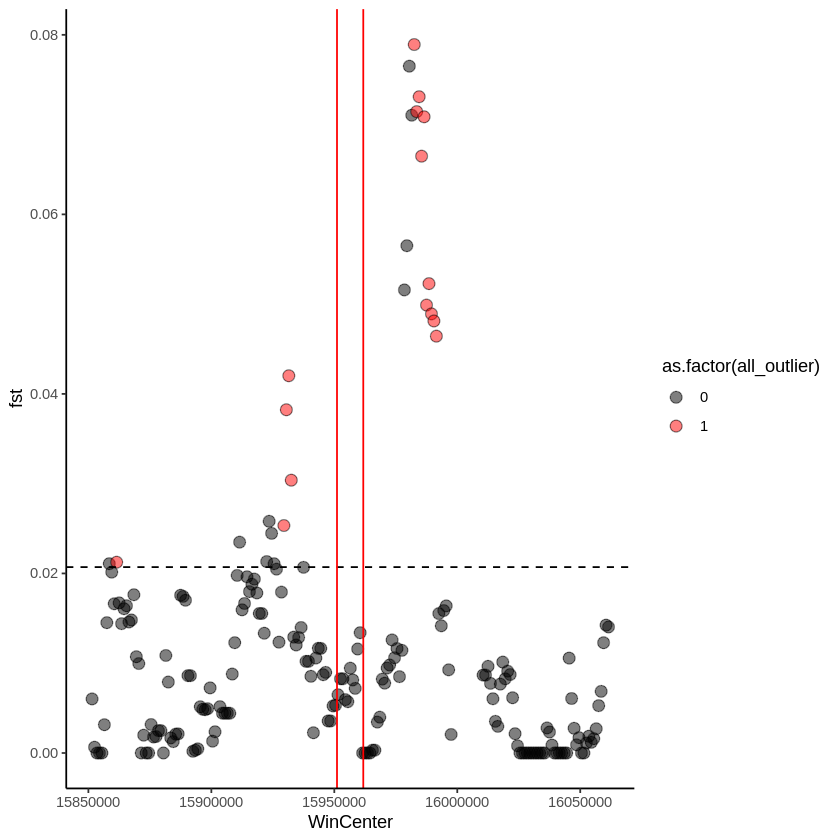

In [22]:
fst_quant <- quantile(testChr_allStats %>% pull(fst), probs = c(0.99))
tp_quant <- quantile(testChr_allStats %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant <- quantile(testChr_allStats %>% pull(delta_td_ur), probs = c(0.01, 0.99))
Ac_outlier_df <- testChr_allStats %>%
    filter(WinCenter >= 15951095 - 100000 & WinCenter <= 15961779 + 100000) %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant[1] | delta_tp_ur >= tp_quant[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant[1] | delta_td_ur >= td_quant[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
Ac_outlier_df %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 3, alpha = 0.5, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        geom_vline(xintercept = 15951095, color = 'red') +
        geom_vline(xintercept = 15961779, color = 'red') + 
        theme_classic()